In [2]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn

from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

#### 1. Import boundaries and population raster

In [3]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,32.668022,0.408476,0.21705,32.509629,"POLYGON ((32.5096294 0.3100581, 32.5097488 0.3...","Kampala, Central Region, Uganda"


In [4]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')

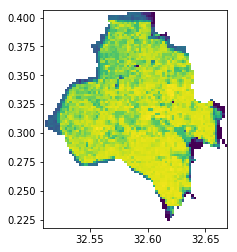

In [7]:
show(pop_raster)

In [9]:
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

In [83]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],1000,1000) # takes xmin, xmax, ymin, ymax

In [84]:
grid=gpd.read_file('grid_KM.shp')

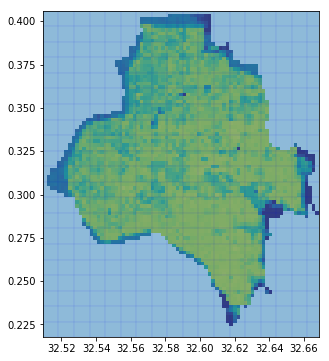

In [85]:
ax = grid.plot(facecolor=None,edgecolor='b',lw=0.1,alpha=0.5,figsize=[6,6])
show(pop_raster, ax=ax)

#### 2. Get POIs

In [20]:
bbox = pop_raster.bounds

amenities = ['hospital','clinic']
POIs = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities)))

In [25]:
POIs = POIs[['amenity','name','lat','lon']]

POIs = gpd.GeoDataFrame(POIs)
POIs['geometry'] = (list(zip(POIs.lon,POIs.lat)))
POIs['geometry'] = POIs.geometry.apply(lambda x: Point(x))

POIs = gpd.sjoin(POIs,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [27]:
print(POIs.amenity.value_counts())
POIs.head(1)

clinic      272
hospital     51
Name: amenity, dtype: int64


,amenity,name,lat,lon,geometry,index_right,bbox_east,bbox_north,bbox_south,bbox_west,place_name
294016124,hospital,Rubaga Hospital,0.303553,32.552608,POINT (32.5526075 0.3035534),0,32.668022,0.408476,0.21705,32.509629,"Kampala, Central Region, Uganda"


#### 3. Count population in fishnet squares


In [86]:
shp = 'grid_KM.shp'
rast = "data/kampala_pop_2.tiff"
z_stats = zonal_stats(shp, rast,stats=['mean'])

In [87]:
grid['pop_density'] = [i['mean'] for i in z_stats]

In [89]:
grid['pop_density'].fillna(0,inplace=True)

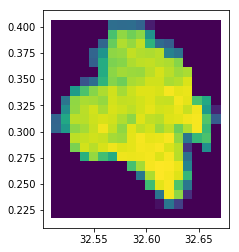

In [91]:
grid.plot(column='pop_density')

In [94]:
sum(grid.pop_density) # This isn't right yet, it says about 2.2 million population (too high)

2224887.9934651735

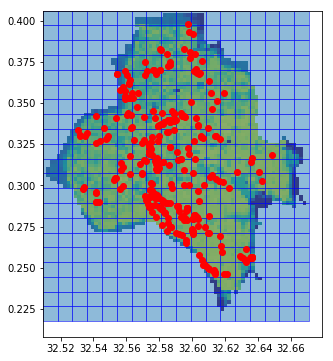

In [96]:
f,ax = plt.subplots(figsize=[6,6])
show(pop_raster, ax=ax)
grid.plot(ax = ax, color=None, edgecolor='b', alpha = 0.5)
POIs.plot(ax=ax, color='r')

#### 4. Create flooded road networks

In [179]:
# Create grid
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [207]:
# Data 
path = 'data/'
tif_10_path = path + '10yr_Kampala.tif'
tif_50_path = path + '50yr_Kampala.tif'
tif_100_path = path + '100yr_Kampala.tif'

In [210]:
raster = rasterio.open(tif_50_path)

In [231]:
node_gdf_proj = node_gdf.copy()
node_gdf_proj = node_gdf_proj.to_crs(raster.crs)

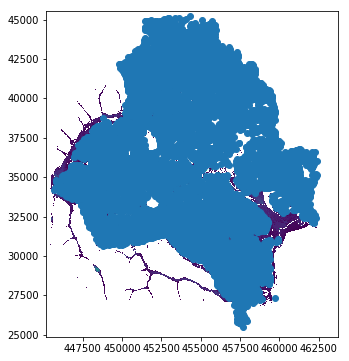

In [232]:
f,ax = plt.subplots(figsize=[6,6])
show(raster, ax = ax)
node_gdf_proj.plot(ax=ax)

In [216]:
node_gdf = gn.node_gdf_from_graph(G)

In [195]:
path = 'data'
tif = '50yrflood_Kampala.tif'
tif_path = os.path.join(path, tif)
print(tif_path)
print(tif_50_path)

data/50yrflood_Kampala.tif
data/50yr_6hr_Flood_ Kampala_5m_Res.tif


In [197]:
G = gn.sample_raster(G, tif_path, property_name = 'flood_depth_10_yr')

In [208]:
G = gn.sample_raster(G, tif_10_path, property_name = 'flood_depth_10_yr')
G = gn.sample_raster(G, tif_50_path, property_name = 'flood_depth_50_yr')
G = gn.sample_raster(G, tif_100_path, property_name = 'flood_depth_100_yr')

In [209]:
gn.example_node(G)

(6241026052, {'y': 0.3487386, 'x': 32.5916098, 'osmid': 6241026052, 'flood_depth_10_yr': -32767.0})


In [118]:
G_node_gdf = gn.node_gdf_from_graph(G)

print("Flooding is positive in {:.1f}% of nodes.".format(
    (G_node_gdf[G_node_gdf.flood_depth > 0].shape[0] / G_node_gdf.shape[0])*100))

print("Flooding exceeds 15 centimeters for {:.1f}% of nodes and exceeds 40 centimeters for {:.1f}% of nodes.".format(
    ((G_node_gdf[G_node_gdf.flood_depth > 0.15].shape[0] / G_node_gdf.shape[0]*100)),
    (G_node_gdf[G_node_gdf.flood_depth > 0.4].shape[0] / G_node_gdf.shape[0])*100))

Flooding is positive in 4.1% of nodes.
Flooding exceeds 15 centimeters for 3.0% of nodes and exceeds 40 centimeters for 0.6% of nodes.


## ANALYSIS
#### 6. Road network to time

In [97]:
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [98]:
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [99]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [100]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [101]:
gn.example_edge(G,1)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a2d7bc0f0>, 'time': 7.693560000000001, 'mode': 'drive'})


#### 7. Snap firms and POIs to graph

In [111]:
grid['centroid_point'] = grid.geometry.centroid
grid.geometry = grid['centroid_point']

In [112]:
grid_with_nearest_node_field = gn.pandana_snap(G, grid, add_dist_to_node_col = True)

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1563: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1565: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [157]:
grid_with_nearest_node_field['time_hours'] = ((grid_with_nearest_node_field.NN_dist / 1000) / 4.5)
grid_with_nearest_node_field['time_minutes'] = grid_with_nearest_node_field.time_hours * 60
grid_with_nearest_node_field['time_seconds'] = grid_with_nearest_node_field.time_hours * 60 * 60

grid_with_nearest_node_field.head(3)

,FID,geometry,pop_density,centroid_point,NN,NN_dist,time_seconds,time_minutes,time_hours
0,0,POINT (32.51374533304759 0.4016926416825147),0.0,POINT (32.51374533304759 0.4016926416825147),6220689098,0.042706,0.034165,0.000569,0.000009
1,1,POINT (32.51374533304759 0.3927094238855439),0.0,POINT (32.51374533304759 0.3927094238855439),6220689098,0.038604,0.030883,0.000515,0.000009
2,2,POINT (32.51374533304759 0.3837262060885732),0.0,POINT (32.51374533304759 0.3837262060885732),6220689098,0.036307,0.029046,0.000484,0.000008


In [114]:
pois_with_nearest_node_field = gn.pandana_snap(G, POIs)
print("grid shape: {}, pois shape: {}".format(grid_with_nearest_node_field.shape, pois_with_nearest_node_field.shape))

grid shape: (378, 6), pois shape: (323, 15)


In [115]:
list_of_nearest_nodes_grid = list(grid_with_nearest_node_field.NN)
list_of_nearest_nodes_pois = list(pois_with_nearest_node_field.NN)

In [159]:
len(list_of_nearest_nodes_grid)

378

In [161]:
grid_with_nearest_node_field.time_seconds.shape

(378,)

#### 8. Get flood raster and intersect it

In [116]:
# Data 
path = 'data'
tif = '50yrflood_Kampala.tif'
tif_path = os.path.join(path, tif)

In [117]:
G = gn.sample_raster(G, tif_path, property_name = 'flood_depth')

In [118]:
G_node_gdf = gn.node_gdf_from_graph(G)

print("Flooding is positive in {:.1f}% of nodes.".format(
    (G_node_gdf[G_node_gdf.flood_depth > 0].shape[0] / G_node_gdf.shape[0])*100))

print("Flooding exceeds 15 centimeters for {:.1f}% of nodes and exceeds 40 centimeters for {:.1f}% of nodes.".format(
    ((G_node_gdf[G_node_gdf.flood_depth > 0.15].shape[0] / G_node_gdf.shape[0]*100)),
    (G_node_gdf[G_node_gdf.flood_depth > 0.4].shape[0] / G_node_gdf.shape[0])*100))

Flooding is positive in 4.1% of nodes.
Flooding exceeds 15 centimeters for 3.0% of nodes and exceeds 40 centimeters for 0.6% of nodes.


#### 9. Calculate baseline OD matrix

In [120]:
def calculate_OD(G, origins, destinations, fail_value, weight = 'time'):
    #### Function for generating an origin: destination matrix  ####
    # REQUIRED: G - a graph containing one or more nodes
    #           fail_value - the value to return if the trip cannot be completed (implies some sort of disruption / disconnected nodes)
    #           origins - a list of the node IDs to treat as origins points
    #           destinations - a list of the node IDs to treat as destination points
    # OPTIONAL: weight - use edge weight of 'time' unless otherwise specified
    # RETURNS:  a numpy matrix of format OD[o][d] = shortest time possible
    # -------------------------------------------------------------------------#

    OD = np.zeros((len(origins), len(destinations)))

    for o in range(0, len(origins)):
        origin = origins[o]
        results_dict = nx.single_source_dijkstra_path_length(G, origin, cutoff = None, weight = weight)

        for d in range(0, len(destinations)):
            destination = destinations[d]
            if destination in results_dict.keys():
                OD[o][d] = results_dict[destination]
            else:
                OD[o][d] = fail_value

    return OD

#### 10. Disrupt network, calculate flooded OD matrix

In [123]:
my_flood_depth = 0.15
fail_value = 999999999999999

In [124]:
G_flood = G.copy()
G_flood = gn.disrupt_network(G_flood, 'flood_depth', my_flood_depth, fail_value)

nodes disrupted: 412
edges disrupted: 1195


In [ ]:
baseline_OD = calculate_OD(G, list_of_nearest_nodes_grid, list_of_nearest_nodes_pois, fail_value)   
flood_OD = calculate_OD(G_flood, list_of_nearest_nodes_grid, list_of_nearest_nodes_pois, fail_value)

In [ ]:
baseline_OD_df = pd.DataFrame(baseline_OD)
flood_OD_df = pd.DataFrame(flood_OD)
flood_OD_df = flood_OD_df[flood_OD_df < fail_value]

#### 11. Travel time to health facilities, before and after

In [130]:
baseline_shortest_times = baseline_OD_df.min(axis=1) / 60
flooded_shortest_times = flood_OD_df.min(axis=1) / 60

In [131]:
baseline_shortest_times.describe()

count    378.000000
mean       3.584045
std        2.261640
min        0.000000
25%        1.646560
50%        3.729781
75%        5.035461
max       12.574331
dtype: float64

In [132]:
flooded_shortest_times.describe()

count    356.000000
mean       3.759606
std        2.286015
min        0.000000
25%        1.850593
50%        3.982158
75%        5.182567
max       12.574331
dtype: float64

In [133]:
baseline_mean_times = baseline_OD_df.mean(axis=1) / 60
flooded_mean_times = flood_OD_df.mean(axis=1) / 60

In [134]:
baseline_mean_times.describe()

count    378.000000
mean      18.783976
std        4.340736
min        9.544481
25%       15.599517
50%       18.881812
75%       21.966269
max       32.181057
dtype: float64

In [135]:
flooded_mean_times.describe()

count    356.000000
mean      22.152967
std        5.104502
min       11.088965
25%       18.079759
50%       22.913214
75%       25.977178
max       37.076133
dtype: float64